# 1-01 Data Postprocessing 

- **Note that data files used here are NOT provided.**

---
## Steps:
### 1. Preprocessing
- [x] Data preparation
- [x] Checking the durations
- [x] Checking the contexts
- [x] Acoustic data processing
    - Normalization
    - Parameter extraction
    - Formant outlier removal
- [ ] Articulatory data processing
    - Normalization
    - PCA
- [ ] Adding consonant context labels

### 2. Sanity checks
- [ ] Compare normalized articulatory and acoustic distance

### 3. Save the result
- [ ] Save
---

## Log
- 2021-01-08 first created

In [47]:
# Basic
import os
import re
import pickle
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.ensemble import IsolationForest

# Visualization
from IPython.display import Image, HTML, display
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Custom
from tools.utils import *
from tools.plots import *
from tools.postproc import *

rand_seed = 0

## Settings

In [56]:
# --- Settings
save_again = True
use_mel = True
drop_f0 = True # f0 column was dropped because f0 tracking failed for many cases (N>5000).

# --- Directories
data_dir = 'data'
plot_dir = 'data_plots'
save_dir = 'data_processed'
vowel_target_file = 'vowel_targets.csv'
grand_mean_file = 'grand_means.csv'
pca_file = 'pca.pkl'
zscore_file = 'zscore.pkl'

# --- Parameters
acous_col = ['F1', 'F2']
artic_col = ['TRx','TRz','TBx','TBz','TTx','TTz','JAWx','JAWz','ULx','ULz','LLx','LLz']
if use_mel:
    acous_col = [c + '_mel' for c in acous_col]
acous_col_norm = [re.sub('_mel', '_norm', ac) for ac in acous_col]
artic_col_norm = [ac+'_norm' for ac in artic_col]
num_points = 5
vowel_mid_point = 0.5 # 0~1
corner_vowels = ['IY1', 'AE1', 'AA1', 'UW1']
vowel_label = ['i', 'ɪ', 'ɛ', 'ʌ', 'ɔ', 'ɑ', 'æ', 'ʊ', 'u']
vowel2ipa = {
    'IY1': 'i',
    'IH1': 'ɪ',
    'EH1': 'ɛ',
    'AO1': 'ʌ',
    'AH1': 'ɔ',
    'AA1': 'ɑ',
    'AE1': 'æ',
    'UH1': 'ʊ',
    'UW1': 'u',
}
num_pca = 3
pca_col = ['PC1','PC2','PC3']

# --- Font
fontpath = '/home/zzandore/.local/share/fonts/Times New Roman 400.ttf'
prop = font_manager.FontProperties(fname=fontpath)
matplotlib.rcParams['font.family'] = prop.get_name()
print('Loaded')

Loaded


---
<h2 style="background-color: yellow;color:black">1. Preprocessing</h2>

### Data preparation

In [3]:
data_files = sorted(glob(os.path.join(data_dir, '*.csv')))
D = pd.concat([pd.read_csv(f) for f in data_files]).reset_index(drop=True)
row_orig = D.shape[0]
print(D.shape)
D.tail()
# 2021-01-11: (266065, 29)

(266065, 29)


,FileID,Speaker,Block,Rate,Sent,Rep,Word,PreVowel,Vowel,PostVowel,...,TBx,TBz,TTx,TTz,JAWx,JAWz,ULx,ULz,LLx,LLz
266060,M04_B12_S60_R01_N,M04,12.0,N,S60,1.0,QUICKLY,W,IH1,END,...,-34.073967,-5.568866,-22.075920,-13.734274,-2.816198,-14.227002,13.855685,1.706465,7.023729,-29.766973
266061,M04_B12_S60_R01_N,M04,12.0,N,S60,1.0,QUICKLY,W,IH1,END,...,-32.697624,-4.340488,-20.543129,-13.195052,-5.784213,-14.481289,12.307539,1.910640,5.783880,-30.607943
266062,M04_B12_S60_R01_N,M04,12.0,N,S60,1.0,QUICKLY,W,IH1,END,...,-31.433746,-3.019826,-19.242910,-12.989389,-7.909608,-14.611296,10.920513,1.851405,4.284643,-31.268976
266063,M04_B12_S60_R01_N,M04,12.0,N,S60,1.0,QUICKLY,W,IH1,END,...,-30.837154,-2.664317,-18.781134,-13.449357,-9.015121,-14.473729,10.387389,1.490509,4.093577,-31.206635
266064,M04_B12_S60_R01_N,M04,12.0,N,S60,1.0,QUICKLY,W,IH1,END,...,-31.065208,-4.580448,-16.539648,-13.305168,-8.395906,-14.456223,11.670880,2.110099,4.565156,-30.190405


In [4]:
# Check value counts to see if tokens are equal across time points
D.TimeAt.value_counts()

0.00    53201
0.75    53201
0.25    53201
1.00    53201
0.50    53201
Name: TimeAt, dtype: int64

In [5]:
# Drop f0 columns because of NaNs and f0 is not used for the subsequent analysis
if drop_f0:
    D.drop(['f0'], inplace=True, axis=1)
    assert 'f0' not in D.columns.to_list()
    print('f0 column has removed')

f0 column has removed


In [6]:
# Drop NaNs
D, ids = drop_na(D)
row_new = D.shape[0]

 60 NaNs were found


In [7]:
# Add "Token" column to make a unique token ID
D = add_unique_token_id(D)

Index ("Token") column is added to the data


In [8]:
print(f'\n\n{row_orig} --> {row_new}: {row_orig-row_new} rows were deleted\n\n')



266065 --> 266005: 60 rows were deleted




In [9]:
# Add columns for the mel-scaled formant frequencies
# Regardless of `use_mel` add mel columns
if use_mel:
    for col in acous_col:
        D[col] = hz_to_mel(D[re.sub("_mel", "", col)])
print(D.shape)
D[acous_col].tail()

(266005, 31)


,F1_mel,F2_mel
266000,579.241884,1615.924560
266001,556.858198,1595.696892
266002,557.869111,1605.240753
266003,552.981019,1591.784901
266004,549.611497,1608.238657


In [10]:
# Get data info
spkr_list = sorted(D.Speaker.unique().tolist())
word_list = sorted(D.Word.unique().tolist())
vowel_list_all = sorted(D.Vowel.unique().tolist())  # all vowels
vowel_list = ["IY1", "IH1", "EH1", "AO1", "AH1", "AA1", "AE1", "UH1", "UW1"]
time_list = D.TimeAt.unique().tolist()
block_list = sorted(D.Block.unique().tolist())
print("Speaker:", spkr_list)
print("Words: num=", len(word_list))
print("Vowels (all):", vowel_list_all)
print("Vowels (selected):", vowel_list)  # 9 vowels selected
print("Blocks:", block_list)
print('Times:', time_list)

Speaker: ['F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M03', 'M04']
Words: num= 1328
Vowels (all): ['AA1', 'AE1', 'AH1', 'AO1', 'EH1', 'IH1', 'IY1', 'UH1', 'UW1']
Vowels (selected): ['IY1', 'IH1', 'EH1', 'AO1', 'AH1', 'AA1', 'AE1', 'UH1', 'UW1']
Blocks: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]
Times: [0.0, 0.25, 0.5, 0.75, 1.0]


In [11]:
# Load palate
pal_files = sorted(glob(os.path.join(data_dir, '*.pkl')))
pal_all = load_palate(pal_files, spkr_list)
print("Loaded")

Loaded


In [12]:
# Make speaker directories under `data_plots`
# - `data_plots` will contain visualizations
# - `data_processed` will contain processed data files and parameter files
if save_again:
    for which_spkr in spkr_list:
        safe_mkdir(os.path.join(plot_dir, which_spkr))
    print('Speaker folders under data_plots were created')
else:
    print('Skipping...')

Speaker folders under data_plots were created


### Check the durations

In [13]:
DN = D.copy()
for spkr in spkr_list:
    DN = remove_short_tokens(DN, spkr, spkr_col='Speaker', dur_col='Duration', 
                            lower_threshold=0.03, upper_threshold=1.)
DN.reset_index(drop=True, inplace=True)
print(D.shape, '-->', DN.shape)
print(f'--------- {(D.shape[0]-DN.shape[0])/D.shape[0]*100:.1f} % removed')
print('Done')

F01: 37250 --> 33210 (4040)
F02: 32625 --> 28110 (4515)
F03: 32925 --> 29385 (3540)
F04: 33845 --> 30615 (3230)
M01: 32400 --> 28595 (3805)
M02: 30755 --> 24755 (6000)
M03: 33095 --> 29080 (4015)
M04: 33110 --> 28040 (5070)
(266005, 31) --> (231790, 31)
--------- 12.9 % removed
Done


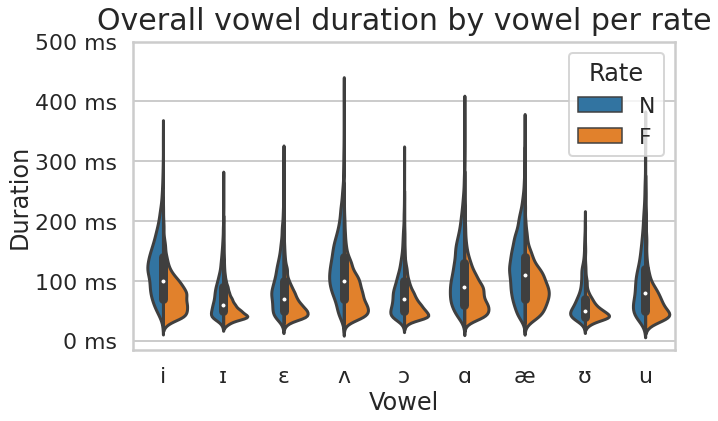

In [14]:
# Overall vowel duration (checking only mid-point)
which_time = 0.5
fig, ax = duration_by_condition_boxplot(
    DN[DN.TimeAt == which_time],
    duration_col="Duration",
    hue="Rate", hue_order=['N','F'],
    condition_col="Vowel",
    condition_list=vowel_list,
    vowel2ipa=vowel2ipa,
)
ax.set_title("Overall vowel duration by vowel per rate", fontsize=30, y=1.02);

In [15]:
# Plot duration by Vowel by Speaker
if save_again:
    condition_col = 'Vowel'
    duration_col = 'Duration'
    hue = 'Rate'
    which_time = 0.5
    
    for spkr in tqdm(spkr_list, total=len(spkr_list)):
        d = DN.loc[(DN.Speaker==spkr)&(DN.TimeAt==which_time)]
        fig, ax = duration_by_condition_boxplot(d, 
                                                duration_col=duration_col, hue=hue, hue_order=['N','F'],
                                                condition_col=condition_col, condition_list=vowel_list)
        plt.suptitle(f'Vowel duration by {condition_col} ({spkr})', fontsize=25);
        fig.savefig(os.path.join(plot_dir, spkr, f'{spkr}_duration.png'))
        plt.close()
    del d, fig
    print('Plots were saved')
else:
    print('Skipping...')

100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Plots were saved


interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

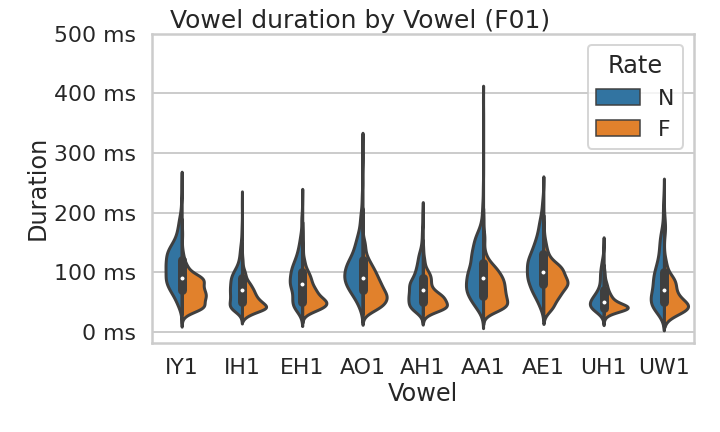

In [16]:
# Check duration plots
def func(which_spkr):
    return Image(filename=os.path.join(plot_dir, which_spkr, f'{which_spkr}_duration.png'), width=500)

interact(func, which_spkr=spkr_list);
func('F01')

### Check the contexts
- This should be re-calculated after outlier removal!

In [17]:
# Remove nasal coda context ('N, NG, M')
DN = DN.loc[(~DN.PostVowel.isin(["N", "NG", "M"]))].reset_index(drop=True)
print(DN.shape)  # (231790, 31)

(231790, 31)


In [18]:
# Remove rhotic coda context (delete 'r')
DN = DN.loc[(DN.PostVowel != "R")].reset_index(drop=True)
print(DN.shape)  # (231790, 31)

(231790, 31)


In [19]:
# Remove rhotic and /w/ onset context
DN = DN.loc[(~DN.PreVowel.isin(['R', 'W']))].reset_index(drop=True)
print(DN.shape)  # (193745, 31)

(193745, 31)


In [20]:
# Exclude where word is 'sp'
DN = DN.loc[DN.Word != 'sp'].reset_index(drop=True)
print('After removing sp', DN.shape) # (193745, 31)

After removing sp (193745, 31)


In [21]:
# Check onset contexts and their counts
print("[h] initial:", (DN.PreVowel == "HH").sum())
print("[p] initial:", (DN.PreVowel == "P").sum())
print("[b] initial:", (DN.PreVowel == "B").sum())
print("[f] initial:", (DN.PreVowel == "F").sum())
print("[v] initial:", (DN.PreVowel == "V").sum())
print("[t] initial:", (DN.PreVowel == "T").sum())
print("[d] initial:", (DN.PreVowel.isin(["D","DH"]).sum()))
print("[s] initial:", (DN.PreVowel == "S").sum())
print("[sh] initial:", (DN.PreVowel == "SH").sum())
print("[k] initial:", (DN.PreVowel == "K").sum())
print("[g] initial:", (DN.PreVowel == "G").sum())
# [h] initial: 1645
# [p] initial: 1393
# [b] initial: 1780
# [f] initial: 1204
# [v] initial: 211

[h] initial: 12790
[p] initial: 12065
[b] initial: 11720
[f] initial: 10850
[v] initial: 1855
[t] initial: 20370
[d] initial: 21435
[s] initial: 12920
[sh] initial: 5455
[k] initial: 13180
[g] initial: 3835


In [22]:
# Check data shape by rate per speaker
for spkr in spkr_list:
    print(spkr, DN.loc[DN.Speaker==spkr].shape)
    print('   ', 'N:', DN.loc[(DN.Speaker==spkr)&(DN.Rate=='N')].shape, 'F:', DN.loc[(DN.Speaker==spkr)&(DN.Rate=='F')].shape)

F01 (27610, 31)
    N: (17955, 31) F: (9655, 31)
F02 (23570, 31)
    N: (14210, 31) F: (9360, 31)
F03 (24175, 31)
    N: (14230, 31) F: (9945, 31)
F04 (25220, 31)
    N: (15060, 31) F: (10160, 31)
M01 (23770, 31)
    N: (14370, 31) F: (9400, 31)
M02 (21390, 31)
    N: (13125, 31) F: (8265, 31)
M03 (24315, 31)
    N: (14940, 31) F: (9375, 31)
M04 (23695, 31)
    N: (14020, 31) F: (9675, 31)


<h3 style="background-color: blue"> Acoustic data processing </h3>

#### Normalization prep
- Center & Rescale based on the vowel mid-point at normal rate

In [57]:
# Get vowel targets (medians) based on the Normal rate
VT = (DN[['Speaker','Vowel','TimeAt']+acous_col+artic_col]
      .loc[DN.Vowel.isin(vowel_list)]
      .groupby(['Speaker','Vowel','TimeAt'])
      .median().reset_index())
if save_again:
    VT.to_csv(os.path.join(save_dir, vowel_target_file), index=False)
    print('saved')
else:
    print('not saving')
print('Vowel median targets table size:', VT.shape)
VT.head(10)

saved
Vowel median targets table size: (360, 17)


,Speaker,Vowel,TimeAt,F1_mel,F2_mel,TRx,TRz,TBx,TBz,TTx,TTz,JAWx,JAWz,ULx,ULz,LLx,LLz
0,F01,AA1,0.00,720.881949,1239.300495,-54.802062,-10.368443,-40.753420,-6.693332,-23.198649,-10.656153,-10.317006,-14.263960,9.069611,4.084249,3.863001,-27.513556
1,F01,AA1,0.25,765.542588,1196.313566,-55.733318,-10.824668,-41.869297,-7.219058,-24.253196,-13.268836,-10.853654,-14.896864,9.062610,3.875587,3.155715,-29.227177
2,F01,AA1,0.50,779.092226,1194.056920,-55.968576,-11.341095,-42.439078,-7.091958,-24.567270,-12.979812,-11.181563,-14.891421,8.879357,3.730438,2.987944,-29.280295
3,F01,AA1,0.75,759.486796,1210.517620,-55.360446,-11.099708,-42.342070,-5.705521,-23.930248,-9.160017,-11.298805,-14.381641,8.648819,3.675443,3.247613,-27.621021
4,F01,AA1,1.00,718.750345,1233.664404,-54.197752,-10.637874,-41.600998,-4.422680,-23.332166,-6.126406,-11.129600,-13.550876,8.559304,3.787000,3.720335,-25.582494
5,F01,AE1,0.00,731.244695,1452.765623,-49.538943,-7.487816,-34.504786,-4.424242,-17.528084,-14.730090,-14.581864,-14.054834,6.666659,4.657577,2.008316,-28.742405
6,F01,AE1,0.25,804.071007,1443.026973,-50.193939,-7.647083,-35.169117,-5.310521,-18.331621,-16.727237,-15.767484,-14.528880,6.530326,4.532128,0.942536,-30.970951
7,F01,AE1,0.50,818.884864,1431.388589,-50.662002,-7.861158,-35.892777,-5.041908,-18.778433,-15.951591,-15.813541,-14.358718,6.466596,4.433545,0.981331,-29.874060
8,F01,AE1,0.75,779.437546,1427.969253,-50.790810,-7.941566,-36.467911,-4.258112,-18.671245,-12.492195,-14.965078,-13.411101,6.732163,4.511330,2.039946,-27.087327
9,F01,AE1,1.00,722.923802,1429.432337,-50.200748,-8.008758,-36.368894,-3.334550,-18.782764,-7.767472,-13.446075,-12.410215,7.262594,4.714907,3.405585,-23.854074


In [58]:
# Get vowel grandmean based on 4 corner vowels per speaker across rate
GM = VT.loc[VT.Vowel.isin(corner_vowels)].groupby(['Speaker']).mean().reset_index()
if save_again:
    GM.to_csv(os.path.join(save_dir, grand_mean_file), index=False)
    print('saved')
else:
    print('not saving')
print('Grandmean table size:', GM.shape)
GM

saved
Grandmean table size: (8, 16)


,Speaker,TimeAt,F1_mel,F2_mel,TRx,TRz,TBx,TBz,TTx,TTz,JAWx,JAWz,ULx,ULz,LLx,LLz
0,F01,0.5,611.241830,1438.205460,-50.810037,-5.096209,-36.378389,-1.350653,-18.668422,-10.558185,-11.419897,-12.907718,8.218076,4.263439,4.105831,-25.424599
1,F02,0.5,638.716298,1441.450591,-50.791516,0.190202,-36.078453,-0.221044,-17.884267,-7.888675,-5.393580,-21.942139,8.263009,5.245579,6.637392,-28.486651
2,F03,0.5,713.408710,1478.694010,-44.371440,-4.409191,-27.867801,-3.202656,-14.807355,-10.815905,-5.866795,-13.887581,10.078971,0.369257,11.248079,-25.990443
3,F04,0.5,669.512603,1427.758773,-44.749368,1.518516,-27.634447,-4.657559,-16.548140,-11.710023,-8.149872,-12.696727,8.708099,6.138846,6.215931,-29.118491
4,M01,0.5,614.063624,1392.288150,-39.832938,-5.279031,-24.591968,-10.065844,-15.533228,-13.259948,-8.991778,-14.915544,12.167379,1.656265,11.694064,-27.900667
5,M02,0.5,585.280628,1337.112562,-58.589998,-6.219843,-35.982848,-1.251803,-13.508098,-13.664979,-8.660078,-14.916457,11.071422,5.915381,13.706997,-27.590397
6,M03,0.5,624.239324,1413.883246,-50.124829,1.400033,-32.889170,0.029107,-16.002714,-10.099288,-11.062350,-18.559174,11.667039,-1.849754,5.833742,-28.584894
7,M04,0.5,674.146780,1406.070353,-42.174089,-3.070967,-30.658797,-3.908331,-18.840680,-9.137367,-3.651535,-13.637589,11.381974,0.820238,8.097631,-25.654547


#### Normalization & Parameter extraction

In [25]:
# Center & Rescale data based on Normal rate
# - Get center-rescale param from acous (aross rates and time)
# - Get zscore param from artic (based on both rates)
DN['AcousVar'] = 0
DN['ArticVar'] = 0
DN['RescaleFactorAcous'] = 0
DN['RescaleFactorArtic'] = 0
grand_mean_col = [re.sub('_mel', '_grandmean', ac) for ac in acous_col]
DN[grand_mean_col] = 0
DN[acous_col_norm] = 0
DN[artic_col_norm] = 0
DN[acous_col_norm] = DN[acous_col_norm].astype(float)
DN[artic_col_norm] = DN[artic_col_norm].astype(float)

Z = {}
for spkr in tqdm(spkr_list, total=len(spkr_list)):
    # grandmean is already calculated based on both rates
    condition = (DN.Speaker==spkr)
    acous = DN.loc[condition, acous_col].values
    artic = DN.loc[condition, artic_col].values
    vowel_targets = VT[(VT.Speaker==spkr)].reset_index()
    grandmean_ac = GM.loc[GM.Speaker==spkr, acous_col].values
    grandmean_ar = GM.loc[GM.Speaker==spkr, artic_col].values

    # Get rescale unit (mean of vector length)
    lengths_ac = np.sqrt(np.sum((acous - grandmean_ac)**2, axis=1))
    rescale_factor_ac = lengths_ac.mean()
    lengths_ar = np.sqrt(np.sum((artic - grandmean_ar)**2, axis=1))
    rescale_factor_ar = lengths_ar.mean()

    # Center & Rescale
    acous = (acous - grandmean_ac) / rescale_factor_ac
    artic = (artic - grandmean_ar) / rescale_factor_ar
    vowel_targets[acous_col] = (vowel_targets[acous_col].values - grandmean_ac) / rescale_factor_ac # update
    vowel_targets[artic_col] = (vowel_targets[artic_col].values - grandmean_ar) / rescale_factor_ar # update
    
    # Calculate variability from the each vowel target in the normalized space
    #lengths = np.sqrt(np.sum(acous**2, axis=1))
    #lengths_artic = np.sqrt(np.sum(artic**2, axis=1))

    # Update
    DN.loc[condition, acous_col_norm] = acous
    DN.loc[condition, ['RescaleFactorAcous']] = rescale_factor_ac
    DN.loc[condition, grand_mean_col] = grandmean_ac
    DN.loc[condition, artic_col_norm] = artic
    DN.loc[condition, ['RescaleFactorArtic']] = rescale_factor_ac
    #DN.loc[condition, ['AcousDist']] = lengths
    #DN.loc[condition, ['ArticDist']] = lengths_artic
    
    # Iterate over vowels for AcousDist and ArticDist
    for which_vowel in vowel_list:
        for which_time in time_list:
            # --- AcousDist
            m = vowel_targets.loc[(vowel_targets.Vowel==which_vowel)&(vowel_targets.TimeAt==which_time), acous_col].values
            #m = (m - grandmean_ac) / rescale_factor_ac
            d = DN.loc[condition&(DN.Vowel==which_vowel)&(DN.TimeAt==which_time), acous_col_norm].values
            dist = np.sqrt(np.sum((d - m)**2, axis=1))
            DN.loc[condition&(DN.Vowel==which_vowel)&(DN.TimeAt==which_time), 'AcousVar'] = dist

            # --- ArticDist
            m = vowel_targets.loc[(vowel_targets.Vowel==which_vowel)&(vowel_targets.TimeAt==which_time), artic_col].values
            #m = (m - grandmean_ar) / rescale_factor_ar
            d = DN.loc[condition&(DN.Vowel==which_vowel)&(DN.TimeAt==which_time), artic_col_norm].values
            dist = np.sqrt(np.sum((d - m)**2, axis=1))
            DN.loc[condition&(DN.Vowel==which_vowel)&(DN.TimeAt==which_time), 'ArticVar'] = dist
        
    # Update normalizing parameters
    Z.update({
        spkr: {
            # Acous
            'acous': {'mean': {acous_col[j]: grandmean_ac[0,j] for j in range(len(acous_col))},
                      'std': {acous_col[j]: rescale_factor_ac for j in range(len(acous_col))}},
            # Artic -- specify N rate here
            'artic': {'mean': {ar:mu for ar, mu in zip(artic_col, grandmean_ar)}, 
                      'std':  {ac: rescale_factor_ar for ac in artic_col}}
        },
        '_info_': 'based on both rates. mean is the grandmean. std is the scaling factor. see whalen 2018'
    })

if save_again:
    with open(os.path.join(save_dir, 'zscore.pckl'), 'wb') as pckl:
        pickle.dump(Z, pckl)
    print('Saved')
else:
    print('Done')
print(DN.shape) # (193745, 51)

100%|██████████| 8/8 [00:22<00:00,  2.85s/it]

Saved
(193745, 51)


In [26]:
# Plot temporal AcousVar by speaker, vowel and rate (before outlier removal)
if save_again:
    sns.set_theme(context='paper')
    for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
        g = sns.catplot(x='Vowel', y='AcousVar', hue='TimeAt', col='Rate', 
                        col_order=['N','F'] , order=vowel_list,
                        data=DN.loc[DN.Speaker==which_spkr], kind='box', aspect=2)
        plt.suptitle(f'{which_spkr}', fontsize=20, y=1.02)
        # Save
        plt.gcf().savefig(os.path.join(plot_dir, which_spkr, f'{which_spkr}_acousvar_before_outlier.png'), bbox_inches='tight')
        plt.close()
else:
    print('Skipping...')

100%|██████████| 8/8 [00:19<00:00,  2.41s/it]


interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

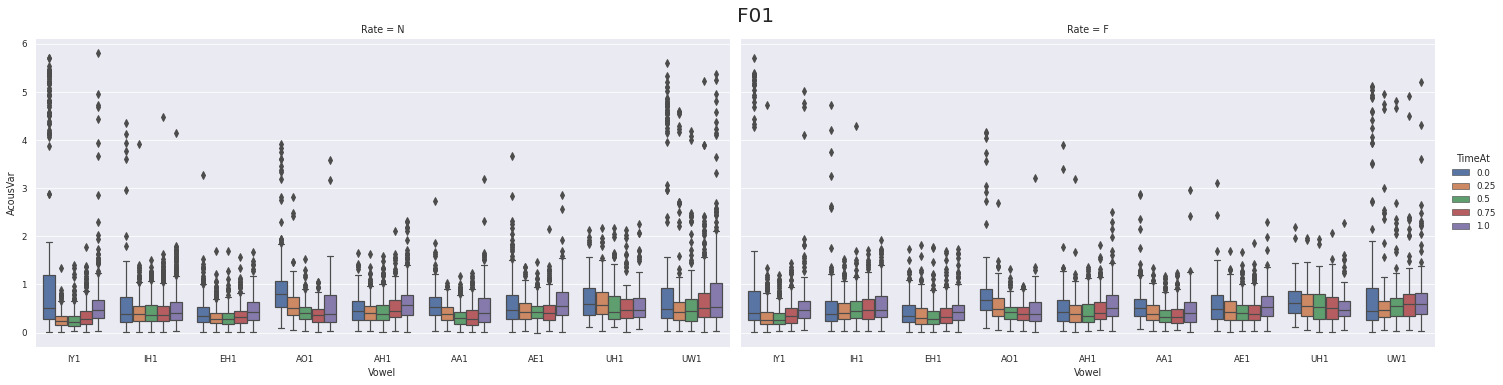

In [27]:
# Check duration plots
def func(which_spkr):
    return Image(filename=os.path.join(plot_dir, which_spkr, f'{which_spkr}_acousvar_before_outlier.png'), width=1000)

interact(func, which_spkr=spkr_list);
func('F01')

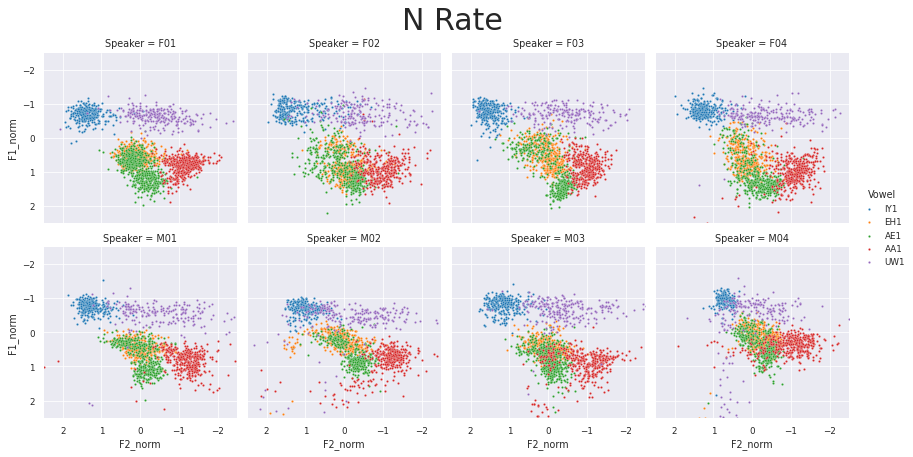

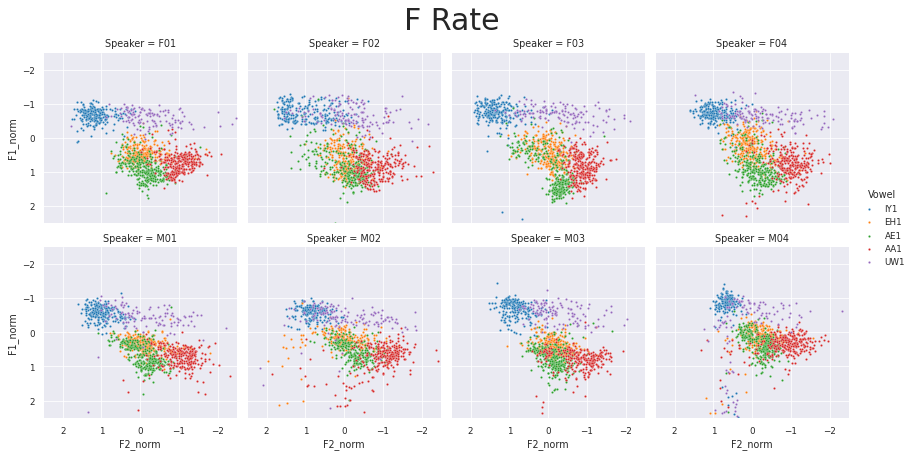

In [28]:
# Check normalized formants (before outlier removal)
time_point = 0.5
custom_vowels = ['IY1','EH1','AE1','AA1','UW1']
palette = sns.color_palette("tab10", len(custom_vowels))
xm, ym = 2.5, 2.5

for which_rate in ['N','F']:
    d = DN.loc[(DN.Rate==which_rate)&(DN.Vowel.isin(custom_vowels))&(DN.TimeAt==time_point)].reset_index(drop=True)
    g = sns.FacetGrid(data=d, col='Speaker', col_wrap=4, height=3, hue='Vowel', hue_order=custom_vowels, palette=palette)
    g.map(sns.scatterplot, 'F2_norm', 'F1_norm', s=5)
    g.add_legend()

    plt.gca().set_xlim([xm, -xm]);
    plt.gca().set_ylim([ym, -ym]);
    plt.suptitle(f'{which_rate.upper()} Rate', y=1.05, fontsize=30);
    plt.gcf().set_facecolor('white')

interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

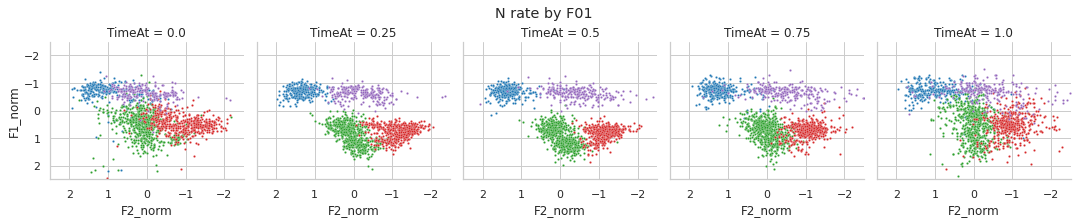

In [29]:
def func(which_spkr, which_rate):
    with sns.plotting_context('poster', font_scale=0.2):
        sns.set_theme(style='whitegrid')
        g = sns.FacetGrid(data=DN.loc[(DN.Speaker==which_spkr)&(DN.Rate==which_rate)&(DN.Vowel.isin(corner_vowels))], 
                          col='TimeAt', col_wrap=num_points, height=3, hue='Vowel', hue_order=custom_vowels, palette=palette)
        g.map(sns.scatterplot, 'F2_norm', 'F1_norm', s=5)
        plt.gca().set_xlim([xm, -xm]);
        plt.gca().set_ylim([ym, -ym]);
        plt.suptitle(f'{which_rate} rate by {which_spkr}', y=1.03);
        plt.gcf().set_facecolor('white')

interact(func, which_spkr=spkr_list, which_rate=['N','F']);
func('F01','N')

#### Formant outlier removal

🧐 Before outlier removal

In [30]:
# Define helper functions
def _plot_dur_vowels(df, which_spkr, which_time, custom_vowels):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), facecolor='white')
    ax1 = plot_duration(ax1, df, which_spkr, custom_vowels, vowel2ipa)
    ax2 = plot_F1F2_df(ax2, df.loc[(df.Speaker==which_spkr)&(df.Rate=='N')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa)
    ax3 = plot_F1F2_df(ax3, df.loc[(df.Speaker==which_spkr)&(df.Rate=='F')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa)
    # Titles
    ax1.set_title('Duration', fontsize=25);
    ax2.set_title('Normal rate', fontsize=25);
    ax3.set_title('Fast rate', fontsize=25);
    fig.suptitle(f'Speaker: {which_spkr}', y=0.9);
    fig.tight_layout()
    return fig, [ax1, ax2, ax3]

def _plot_dur_vowel_spaces(df, which_spkr, which_time, custom_vowels):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), facecolor='white')
    # --- Duration plot
    ax1 = plot_duration(ax1, df.loc[df.Speaker==which_spkr], which_spkr, custom_vowels, vowel2ipa)
    # --- Ellipse plot
    ax2 = plot_F1F2_df(ax2, df.loc[(df.Speaker==which_spkr)&(df.Rate=='N')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa, 
                       center_only=False,
                       ellipse_only=True,
                       ellipse_linestyle='-',
                      )
    ax2 = plot_F1F2_df(ax2, df.loc[(df.Speaker==which_spkr)&(df.Rate=='F')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', show_label=False, 
                       center_only=False,
                       ellipse_only=True,
                       ellipse_linestyle='--',
                      )
    # Prettify
    l1, = ax2.plot([], [], 'k-', linewidth=2)
    l2, = ax2.plot([], [], 'k--', linewidth=2)
    ax2.legend([l1, l2], ['N','F'], fontsize=10)

    # --- Line plot
    ax3 = plot_F1F2_df(ax3, df.loc[(df.Speaker==which_spkr)&(df.Rate=='N')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa, 
                       center_only='median',
                       connected_linestyle='-'
                      )
    ax3 = plot_F1F2_df(ax3, df.loc[(df.Speaker==which_spkr)&(df.Rate=='F')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', show_label=False, 
                       center_only='median',
                       connected_linestyle='--'
                      )
    # Prettify
    l1, = ax3.plot([], [], 'k-', linewidth=2)
    l2, = ax3.plot([], [], 'k--', linewidth=2)
    ax3.legend([l1, l2], ['N','F'], fontsize=10)

    # Titles
    ax1.set_title('Duration', fontsize=25);
    ax2.set_title('Vowel space (ovoids)', fontsize=25);
    ax3.set_title('Vowel space (quadrilateral)', fontsize=25);

    fig.suptitle(f'Speaker: {which_spkr}', y=0.9);
    fig.tight_layout()
    return fig, [ax1, ax2, ax3]

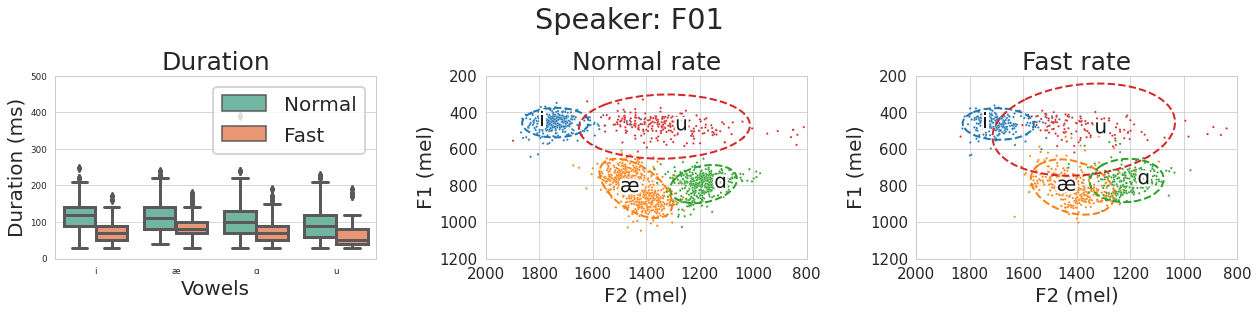

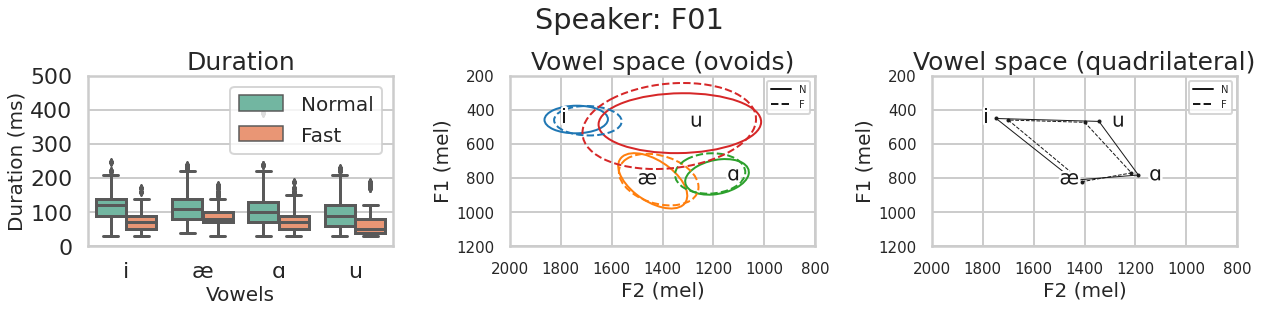

In [31]:
# Plot overall duration and formant patterns for checking
which_spkr = 'F01'
which_time = 0.5
custom_vowels = corner_vowels

fig, arr = _plot_dur_vowels(DN, which_spkr, which_time, custom_vowels)
fig, arr = _plot_dur_vowel_spaces(DN, which_spkr, which_time, custom_vowels)

In [32]:
if save_again:
    for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
        # Plot
        with sns.plotting_context(context='poster'):
            sns.set_style("whitegrid", {'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
            fig, arr = _plot_dur_vowels(DN, which_spkr, which_time, custom_vowels)
        
        # Save
        fig.savefig(os.path.join(plot_dir, which_spkr, f'{which_spkr}_before_outlier.png'), bbox_inches="tight")
        plt.close()
    del fig, arr
    print('Done')
else:
    print('Skipped')

100%|██████████| 8/8 [00:09<00:00,  1.16s/it]

Done


interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

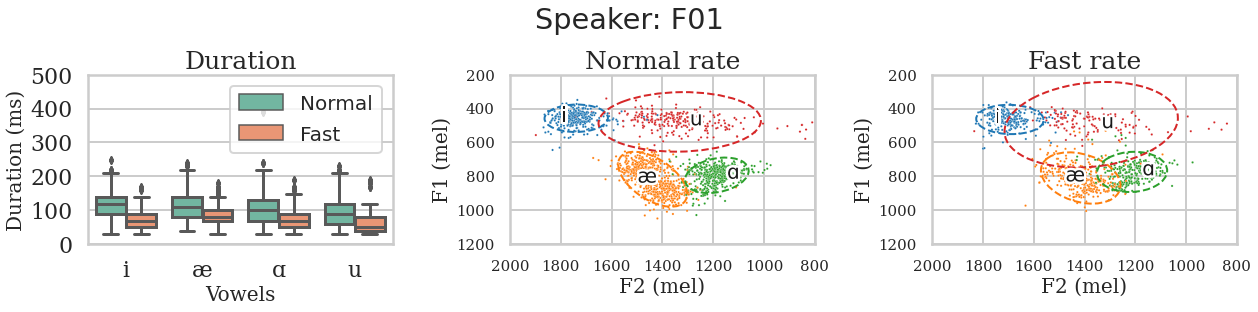

In [52]:
# Check duration plots
def func(which_spkr):
    return Image(filename=os.path.join(plot_dir, which_spkr, f'{which_spkr}_before_outlier.png'), width=1000)

interact(func, which_spkr=spkr_list);
func('F01')

👹 After outlier removal

- Two methods: IQR or IsolationTree
- Outlier removal is based on the vowel acoustic midpoints

In [34]:
# Select which method to use to remove outliers
removal_method = "IsolationTree"  # IQR or IsolationTree

if removal_method == 'IQR':
    lower_bound = 0.25
    upper_bound = 0.75
    
elif removal_method == 'IsolationTree':
    #outliers_fraction = 0.1
    outliers_fraction = 'auto'

print('Method chosen:', removal_method)

Method chosen: IsolationTree


In [35]:
def _remove_acous_outlier_single_variable(df, which_spkr, which_vowel, which_rate, acous_column, 
                                         spkr_col='Speaker', vowel_col='Vowel', rate_col='Rate', time_col='TimeAt',
                                         ref_time=0.5, id_col='Token',
                                         lower_bound=0.25, upper_bound=0.75):
    '''Remove acoustic outlier based on a single variable (e.g., AcousVar, F1 etc.)
    
    df: the entire dataframe (without conditional filtering)
    acous_column: eg. 'F1', 'AcousVar' (NOT this: ['F1_mel', 'F2_mel'])
    ref_time: reference time point
    id_col: unique token id column
    '''
    d = df.loc[(
        (df[spkr_col]==which_spkr)
        &(df[vowel_col]==which_vowel)
        &(df[rate_col]==which_rate)
        &(df[time_col]==ref_time)
    )]
    
    lb, ub = iqr_bounds(d, acous_column, lb=lower_bound, ub=upper_bound)
    outliers = d.loc[(d[acous_column]<lb) | (d[acous_column]>ub)]
    unique_tokens = outliers[id_col].unique().tolist()
    df = df.loc[~(df[id_col].isin(unique_tokens))]
    df.reset_index(drop=True, inplace=True)
    return df, unique_tokens

In [36]:
# This part is data-specific
DF = DN.copy() 

acous_column = 'AcousVar'
total_tokens = DF.Token.unique()[-1]
which_time = 0.5 # mid point
removed_tokens = 0

stat = []
if save_again:
    # Iterate over speakers
    for i in tqdm(range(len(spkr_list))):
        spkr = spkr_list[i]
        # Iterate over vowels
        for vowel in vowel_list:
            # Iterate over speech rate
            for rate in ['N','F']:
                ########################################
                if removal_method == 'IQR':
                    # ----- IQR method
                    DF, unique_tokens = _remove_acous_outlier_single_variable(
                        DF, spkr, vowel, rate, acous_column, 
                        ref_time=0.5, id_col='Token',
                        lower_bound=0.25, upper_bound=0.75)
                    removed_tokens += len(unique_tokens)

                ########################################
                elif removal_method == 'IsolationTree':
                    # Acous
                    d = DF.loc[(DF.Speaker == spkr) & (DF.Vowel == vowel) & (DF.Rate == rate) & (DF.TimeAt == which_time)]
                    X = d[acous_col].values
                    clf = IsolationForest(n_estimators=100, warm_start=True, contamination=outliers_fraction, random_state=rand_seed)
                    clf.fit(X)
                    Y_acous = clf.predict(X)  # predict
                    XX = d.iloc[Y_acous == 1]
                    acous_out = sum(Y_acous == -1)/len(Y_acous)
                    # Update
                    unique_tokens = d.iloc[Y_acous == -1]['Token'].unique()
                    DF.drop(DF.loc[DF.Token.isin(unique_tokens)].index, inplace=True)
                    DF.reset_index(drop=True)
                    removed_tokens += len(unique_tokens)

                    # Artic
                    d = DF.loc[(DF.Speaker == spkr) & (DF.Vowel == vowel) & (DF.Rate == rate) & (DF.TimeAt == which_time)]
                    X = d[artic_col].values
                    clf2 = IsolationForest(n_estimators=100, warm_start=True, contamination=outliers_fraction, random_state=rand_seed)
                    clf2.fit(X)
                    Y_artic = clf2.predict(X)  # predict
                    dd = d.iloc[Y_artic == 1]  # filtered data
                    artic_out = sum(Y_artic == -1)/len(Y_artic)
                    # Update
                    unique_tokens = d.iloc[Y_artic == -1]['Token'].unique()
                    DF.drop(DF.loc[DF.Token.isin(unique_tokens)].index, inplace=True)
                    DF.reset_index(drop=True)
                    removed_tokens += len(unique_tokens)

                    #stat.append([spkr, vowel, cond, acous_out, (1 - acous_out)*artic_out, acous_out + (1 - acous_out)*artic_out])

    # --- Based on DN
    print(f'Original:{DN.shape} ==> Cleaned:{DF.shape}')
    print(f'Reduced about {(len(DN)-len(DF))/len(DN)*100:.2f} %')
    print(f'Tokens reduced {removed_tokens} ({removed_tokens/total_tokens*100:.2f} %) from total of {total_tokens}')
else:
    # If not save_again
    # just load the already cleaned data file
    DF = pd.read_csv(new_file)
    print('Loaded from saved data')

#--- IsolationTree: outliers fraction='auto'
# Original:(193745, 51) ==> Cleaned:(143100, 51)
# Reduced about 26.14 %
# Tokens reduced 10129 (19.04 %) from total of 53199    

#--- IsolationTree: outliers fraction=0.1
# Original:(193745, 51) ==> Cleaned:(156460, 51)
# Reduced about 19.24 %
# Tokens reduced 7457 (14.02 %) from total of 53199

#--- IQR
# Original:(193745, 51) ==> Cleaned:(185630, 51)
# Reduced about 4.19 %
# Tokens reduced 1623 (3.05 %) from total of 53199

100%|██████████| 8/8 [01:32<00:00, 11.57s/it]

Original:(193745, 51) ==> Cleaned:(143100, 51)
Reduced about 26.14 %
Tokens reduced 10129 (19.04 %) from total of 53199


In [38]:
# Check if each time point have the same data points
DF.TimeAt.value_counts()

# 0.00    28620
# 0.75    28620
# 0.25    28620
# 1.00    28620
# 0.50    28620

0.00    28620
0.75    28620
0.25    28620
1.00    28620
0.50    28620
Name: TimeAt, dtype: int64

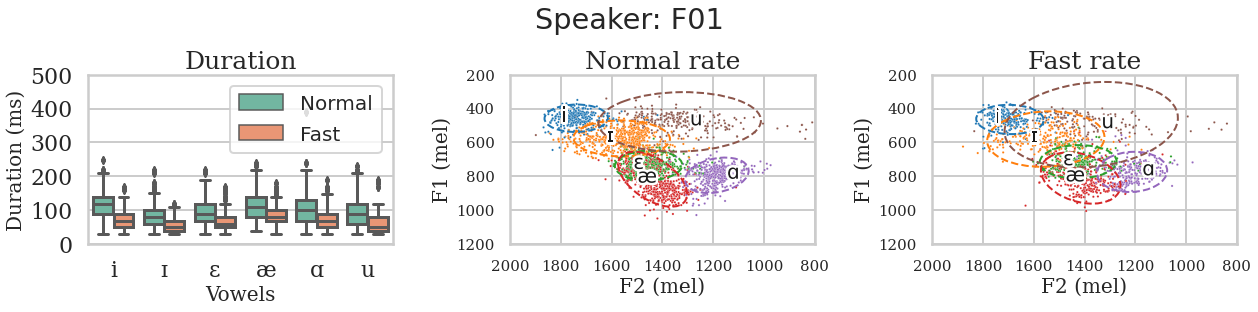

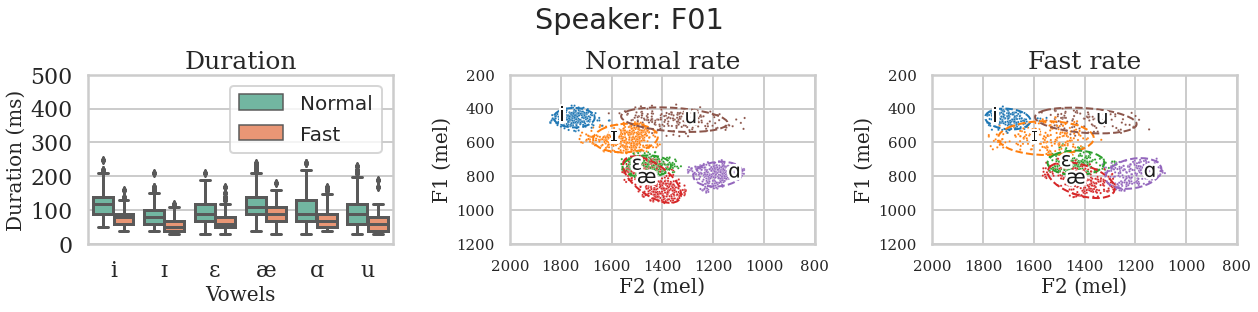

In [39]:
# Check the result of the ourlier removal quickly
# Quick check (for myself)
which_spkr = 'F01'
which_time = 0.5
custom_vowels = ['IY1', 'IH1', 'EH1', 'AE1', 'AA1', 'UW1']

if len(acous_col) == 3:
    fig, arr = plt.subplots(1, 5, figsize=(20,5), facecolor='white')
    plot_dur_formants_by_rate(DF.loc[(DF.Speaker==which_spkr)&(DF.TimeAt==which_time)], arr, vowel_list, 
                              x='Vowel', y='Duration', hue='Rate', 
                              title=f'Plot by Speech Rate ({which_spkr})',
                              use_mel=use_mel);
if len(acous_col) == 2:
    # Before outlier removal
    with sns.plotting_context(context='poster'):
        sns.set_style("whitegrid", {'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
        fig, arr = _plot_dur_vowels(DN, which_spkr, which_time, custom_vowels)
        
    # After outlier removal
    with sns.plotting_context(context='poster'):
        sns.set_style("whitegrid", {'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
        fig, arr = _plot_dur_vowels(DF, which_spkr, which_time, custom_vowels)

In [42]:
if save_again:
    which_time = 0.5
    custom_vowels = ['IY1', 'IH1', 'EH1', 'AE1', 'AA1', 'UW1']
    
    for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
        # Plot
        # --- vowel space with point distribution
        with sns.plotting_context(context='poster'):
            sns.set_style("whitegrid", {'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
            fig, arr = _plot_dur_vowels(DF, which_spkr, which_time, custom_vowels)
            
        # Save
        fig.savefig(os.path.join(plot_dir, which_spkr, f'{which_spkr}_after_outlier.png'), bbox_inches="tight")
        plt.close()
        
        # --- vowel spaces as in ovoids and quadrilateral
        with sns.plotting_context(context='poster'):
            sns.set_style("whitegrid", {'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
            fig, arr = _plot_dur_vowel_spaces(DF, which_spkr, which_time, custom_vowels)
            
        # Save
        fig.savefig(os.path.join(plot_dir, which_spkr, f'{which_spkr}_after_outlier_ovoids.png'), bbox_inches="tight")
        plt.close()
    print('Done')
else:
    print('Skipping...')

100%|██████████| 8/8 [00:26<00:00,  3.25s/it]

Done


interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

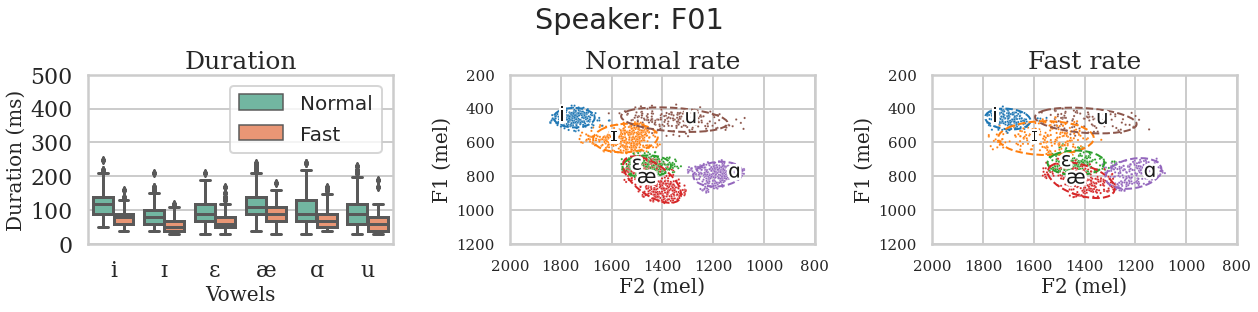

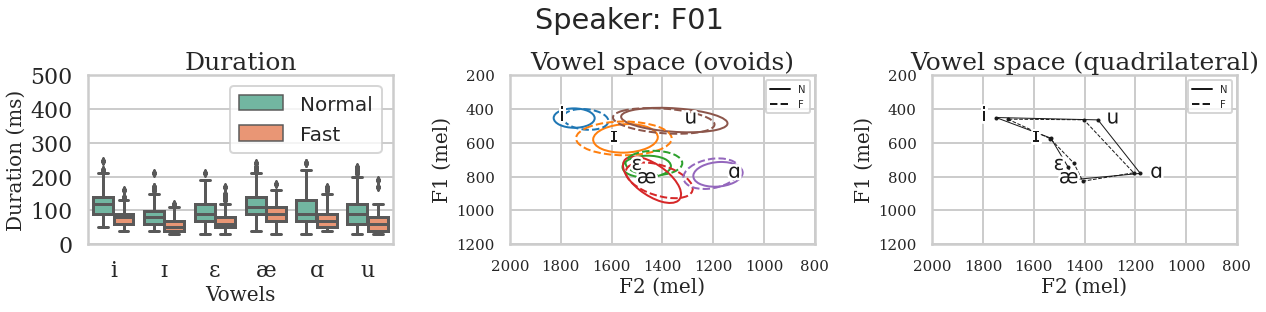

In [53]:
# Check duration plots
def func(which_spkr):
    file1 = os.path.join(plot_dir, which_spkr, f'{which_spkr}_after_outlier.png')
    file2 = os.path.join(plot_dir, which_spkr, f'{which_spkr}_after_outlier_ovoids.png')
    image1 = Image(filename=file1, width=1000)
    image2 = Image(filename=file2, width=1000)
    return display(image1, image2)

interact(func, which_spkr=spkr_list);
func('M04')

<h1 style="color:red"> ISSUE: M04's /ɪ/ and /u/ formant distribution are inaccurate. </h1>

- 1) Re-do outlier removal for M04 with different parameters 
- 2) Re-extract for M04

<h3 style="background-color: blue">Articulatory data processing </h3>

### Check NaNs

In [54]:
num_nans = DF[artic_col].isna().sum().sum()
if num_nans > 0:
    raise Exception(f"There are {num_nans} NaNs! Check your sensor data")
else:
    print("No NaNs were found")

No NaNs were found


In [55]:
# Reset data
DF.reset_index(drop=True, inplace=True)

### Run PCA and save params
- PCA is based on the normal rate and data from acoustic-mid points

# START FROM HERE: 

In [ ]:
# Save
if save_again:
    which_rate = 'N'
    which_time = 0.5
    PC = {}
    for i in tqdm(range(len(spkr_list))):
        spkr = spkr_list[i]
        data = DF.loc[(DF.Speaker==spkr), artic_col].values
        scaler = Scaler(spkr, Z)
        zdata = scaler.transform(data, 'artic')

        # Regular PCA
        pca = PCA(n_components=num_pca)
        pca.fit(zdata)
        PC.update({
            spkr: {
                'pca': pca,
                'components': pca.components_.tolist(),
                'explained_variance_ratio_': pca.explained_variance_ratio_.tolist(),
                'singular_values_': pca.singular_values_.tolist(),
                'info': f'regular pca, extracted {get_date()}'}})

    # Save
    with open(os.path.join(save_dir, pca_file), 'wb') as pckl:
        pickle.dump(PC, pckl)
    print(file_name, 'Saved')
else:
    # If parameters are saved before, just load it!
    with open(os.path.join(save_dir, pca_file), 'rb') as pckl:
        PC = pickle.load(pckl)
    print(file_name, 'Loaded')

---
<h2 style="background-color: yellow;color:black">2. Sanity checks</h2>

- Compare AcousVar and ArticVar (static, dynamic)

---
## 3. Save the result

# END OF THE NOTEBOOK